A simplefied architecture for stain 2 stain translation with leave one marker out. The input are images with varying numbers of channels (panel markers differ by study). The input is being reducted to 3D to fit to a Resnet50 encoder. The embeddings are being fed to a U-Net decoder. 

# imports

In [1]:
!pip install pytorch_msssim
!pip install imagecodecs
!pip install torchmetrics
!pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import os
import psutil
import shutil
import numpy as np
import pandas as pd
import tifffile
import zipfile
import imagecodecs
import gc
import time
import glob
from collections import Counter, OrderedDict
import cv2
import random
from scipy.stats import pearsonr
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import weight_norm
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from pytorch_msssim import ssim
from tqdm import tqdm
import torchvision.utils as vutils
from torchmetrics.image.fid import FrechetInceptionDistance

import matplotlib.pyplot as plt
params = {'axes.titlesize': 30,
          'legend.fontsize': 16,
          'figure.figsize': (16, 10),
          'axes.labelsize': 16,
          'axes.titlesize': 12,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'figure.titlesize': 30}

plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#print(device)
#print(torch.cuda.get_device_name(0))
#print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
#print(f"Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
#print(f"Max allocated: {torch.cuda.max_memory_allocated(0)/1024**2:.2f} MB")
#!free -h

# functions

In [4]:
def to_hwc(img):
    if img.ndim == 2:
        img = img[..., None]
    if img.shape[0] < img.shape[1] and img.shape[0] < img.shape[2]:
        img = np.transpose(img, (1, 2, 0))
    return img.astype(np.float32, copy=False)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_model(model, path):
    state_dict = torch.load(path)
    # If data parallel wrapper, keys start with 'module.'
    if list(state_dict.keys())[0].startswith("module."):
        # Remove 'module.' prefix from all keys:
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_key = k.replace("module.", "")
            new_state_dict[new_key] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)
    return model
    
def fit_preprocessing(
    train_files,
    target_idx,
    control_markers_indices,
    n_components=3,
    batch_size=100_000,
    cofactor=5.0,
    eps=1e-8,
):
    """
    Fit channel-wise regressions and incremental PCA on residuals from IMC training images with lazy loading.
    Returns: (regression_models, pca, pca_mean, pca_std, input_channels)
    """

    # Discover channel setup from the first image
    input_channels = []
    img0 = to_hwc(tifffile.imread(train_files[0]))
    print(f"......example image shape: {img0.shape}")
    H, W, C = img0.shape
    input_channels = [c for c in range(C) if c != target_idx and c not in control_markers_indices]
    K = len(input_channels)
    del img0; gc.collect()

    if not input_channels:
        print(f"Warning: no inputs for target {target_idx} with controls {control_markers_indices}.")
        return None, None, None, None, input_channels

    # 1. Fit regressions with SGDRegressor (partial_fit: true "streaming" mode)
    regression_models = {}
    first_pass = {}

    for j in input_channels:
        regression_models[j] = SGDRegressor(max_iter=1000, tol=1e-3)
        first_pass[j] = True

    for c, f in enumerate(train_files):
        if c % int(len(train_files)/2) == 0 or c == len(train_files)-1:
            print(f"......extracting control and trg markers: {c+1} / {len(train_files)}")
        img = to_hwc(tifffile.imread(f))
        Xc = img[..., control_markers_indices].reshape(-1, len(control_markers_indices))
        for j in input_channels:
            y = img[..., j].reshape(-1)
            if first_pass[j]:
                regression_models[j].partial_fit(Xc, y)
                first_pass[j] = False
            else:
                regression_models[j].partial_fit(Xc, y)
        del img, Xc, y; gc.collect()

    # 2. Incremental PCA on residuals (streamed, as before)
    if n_components > K:
        print(f"n_components {n_components} > residual dim {K}; using {K}.")
        n_components = K
    pca = IncrementalPCA(n_components=n_components)

    for c, f in enumerate(train_files):
        if c % int(len(train_files)/2) == 0 or c == len(train_files):
            print(f"......fitting regression: {c+1} / {len(train_files)}")

        img = to_hwc(tifffile.imread(f))
        Xc = img[..., control_markers_indices].reshape(-1, len(control_markers_indices))
        R = np.empty((Xc.shape[0], K), dtype=np.float32)
        for k, j in enumerate(input_channels):
            y = img[..., j].reshape(-1)
            y_pred = regression_models[j].predict(Xc)
            R[:, k] = y - y_pred.astype(np.float32, copy=False)
        R = np.arcsinh(R / cofactor, dtype=np.float32)
        for s in range(0, R.shape[0], batch_size):
            batch = R[s : s + batch_size]
            pca.partial_fit(batch)
        del img, Xc, R; gc.collect()

    # 3. Compute mean/std of PCA space (streamed)
    total = 0
    sum_z = np.zeros(n_components, dtype=np.float64)
    sumsq_z = np.zeros(n_components, dtype=np.float64)
    
    for c, f in enumerate(train_files):
        if c % int(len(train_files)/2) == 0 or c == len(train_files):
            print(f"......normalization: {c+1} / {len(train_files)}")

        img = to_hwc(tifffile.imread(f))
        Xc = img[..., control_markers_indices].reshape(-1, len(control_markers_indices))
        R = np.empty((Xc.shape[0], K), dtype=np.float32)
        for k, j in enumerate(input_channels):
            y = img[..., j].reshape(-1)
            y_pred = regression_models[j].predict(Xc)
            R[:, k] = y - y_pred.astype(np.float32, copy=False)
        R = np.arcsinh(R / cofactor, dtype=np.float32)
        for s in range(0, R.shape[0], batch_size):
            Z = pca.transform(R[s : s + batch_size]).astype(np.float32)
            sum_z += Z.sum(axis=0)
            sumsq_z += (Z * Z).sum(axis=0)
            total += Z.shape[0]
        del img, Xc, R, Z; gc.collect()

    if total == 0:
        print("Warning: no residuals seen for PCA stats; using zeros/ones.")
        pca_mean = np.zeros(n_components, dtype=np.float32)
        pca_std = np.ones(n_components, dtype=np.float32) * eps
    else:
        pca_mean = (sum_z / total).astype(np.float32)
        var = (sumsq_z / total) - (pca_mean.astype(np.float64) ** 2)
        pca_std = (np.sqrt(np.maximum(var, 0.0)) + eps).astype(np.float32)

    # Print variance captured by PCs if possible
    if hasattr(pca, "explained_variance_ratio_") and pca.explained_variance_ratio_ is not None:
        pct = pca.explained_variance_ratio_[:n_components].sum() * 100.0
        print(f"......PCA projection to {n_components}D captures {pct:.2f}% variance")

    return regression_models, pca, pca_mean, pca_std, input_channels

def preprocess_image(
    file_path,
    target_idx,
    control_markers_indices,
    regression_models,
    pca,
    pca_mean,
    pca_std,
    input_channels,
    n_components=3,
    cofactor=5.0,
    chunk_size=100_000
):
    """
    Load and preprocess a single IMC image lazily by:
    - loading image,
    - normalizing target,
    - computing residuals from regression,
    - arcsinh transform,
    - PCA transform in batches,
    - Z-score normalization of PCA features,
    - return PyTorch tensors for model input.
    """

    def to_hwc(img):
        if img.ndim == 2:
            img = img[..., None]
        if img.shape[0] < img.shape[2] and img.shape[0] < img.shape[1]:
            img = np.transpose(img, (1, 2, 0))
        return img.astype(np.float32, copy=False)

    img = tifffile.imread(file_path)
    img = to_hwc(img)
    H, W, C = img.shape
    filename = os.path.basename(file_path)

    # Normalize target channel intensities with arcsinh and min-max
    target_data = img[..., target_idx]
    y_arc = np.arcsinh(target_data / cofactor).astype(np.float32)
    y_min, y_max = y_arc.min(), y_arc.max()
    y_norm = (y_arc - y_min) / (y_max - y_min + 1e-8)
    y_tensor = torch.from_numpy(y_norm[None, ...]).float()  # (1, H, W)

    # Prepare control channel matrix
    n_ctrl = len(control_markers_indices)
    K = len(input_channels)
    Xc = img[..., control_markers_indices].reshape(-1, n_ctrl)           # (N, n_ctrl)
    Yin = np.stack([img[..., j].reshape(-1) for j in input_channels], 1)  # (N, K)

    # Stack regression coef and intercept for vectorized prediction
    B = np.stack([regression_models[j].coef_ for j in input_channels], axis=-1).astype(np.float32)  # (n_ctrl, K)
    b = np.array([regression_models[j].intercept_ for j in input_channels], dtype=np.float32)       # (K,)
    b = b.flatten()

    # Predict residuals Y - regression(X)
    Yhat = Xc @ B + b                                                # (N, K)
    R = Yin - Yhat
    R = np.arcsinh(R / cofactor).astype(np.float32)

    # PCA transform in chunks, for low memory
    N = R.shape[0]
    Z = np.empty((N, n_components), dtype=np.float32)
    for s in range(0, N, chunk_size):
        e = s + chunk_size
        Z[s:e] = pca.transform(R[s:e])

    # Z-score normalize PCA components
    Z = (Z - pca_mean) / (pca_std + 1e-8)
    Z = Z.reshape(H, W, n_components)

    # Convert PCA tensor to channel-first for PyTorch
    x_tensor = torch.from_numpy(Z).permute(2, 0, 1).contiguous().float()  # (C, H, W)

    return x_tensor, y_tensor, filename


def apply_preprocessing(
    files,
    target_idx,
    control_markers_indices,
    regression_models,
    pca,
    pca_mean,
    pca_std,
    input_channels,
    n_components=3,
    cofactor=5.0,
    chunk_size=100_000
):
    X_pca_tensor, Y_norm_list, filenames = [], [], []
    
    for c, f in enumerate(files):
        if c % int(len(files)/2) == 0 or c == len(files):
            print(f"......applying preprocessing: {c+1} / {len(files)}")

        x_tensor, y_tensor, filename = preprocess_image(
            f, target_idx, control_markers_indices, regression_models, pca,
            pca_mean, pca_std, input_channels, n_components, cofactor, chunk_size
        )
        X_pca_tensor.append(x_tensor)
        Y_norm_list.append(y_tensor)
        filenames.append(filename)
    return X_pca_tensor, Y_norm_list, filenames
    
def pad_collate(batch):
    """
    Pads all tensors in a batch to the largest size.
    Also returns original sizes for cropping.
    """
    X_list, Y_list, original_sizes = zip(*batch)

    max_H = max([x.shape[1] for x in X_list])
    max_W = max([x.shape[2] for x in X_list])

    padded_X_list = []
    padded_Y_list = []

    for x_tensor, y_tensor in zip(X_list, Y_list):
        pad_H = max_H - x_tensor.shape[1]
        pad_W = max_W - x_tensor.shape[2]

        padded_X = F.pad(x_tensor, (0, pad_W, 0, pad_H))
        padded_Y = F.pad(y_tensor, (0, pad_W, 0, pad_H))

        padded_X_list.append(padded_X)
        padded_Y_list.append(padded_Y)


    return torch.stack(padded_X_list), torch.stack(padded_Y_list), original_sizes

def train_model(model, train_loader, val_loader, device, title,
                epochs=50, 
                lr=1e-3, 
                alpha=0.8,          # weight for Huber; (1 - alpha) for SSIM
                huber_beta=1.0,     
                grad_clip=1.0,
                use_amp=True,
                patience=10, 
                save_path="best_model.pth",
                dataset=None):

    """
    Loss = alpha * Huber(y_hat, y) + (1 - alpha) * (1 - SSIM(y_hat_norm, y_norm)).
    - Huber is on intensities.
    - SSIM is per-image min-max normalized to [0,1].
    """

    model.to(device)
    
    save_path = datsset+"_"+title+"_"+save_path
    
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3) #change, was 3
    scaler = GradScaler(enabled=use_amp)

    train_losses, val_losses = [], []
    best_val, best_state, best_epoch = float("inf"), None, None
    no_improve = 0
    epsilon = 1e-8

    for epoch in range(epochs):
        # Training loop unchanged
        model.train()
        running = 0.0
        for x, y, original_sizes in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            B, _, H_padded, W_padded = x.shape  # Padded dimensions

            opt.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', enabled=use_amp):
                yhat = model(x)

                hub_sum = 0.0
                ssim_sum = 0.0
                for i in range(B):
                    h, w = original_sizes[i]
                    y_i = y[i:i+1, :, :h, :w]  # Ground truth (cropped)
                    yhat_i = yhat[i:i+1, :, :h, :w]  # Prediction (cropped)

                    hub_i = F.smooth_l1_loss(yhat_i, y_i, beta=huber_beta, reduction="mean")
                    hub_sum += hub_i

                    y_min, y_max = y_i.min().detach(), y_i.max().detach()
                    yh_min, yh_max = yhat_i.min().detach(), yhat_i.max().detach()
                    y_n = (y_i - y_min) / (y_max - y_min + epsilon)
                    yhat_n = (yhat_i - yh_min) / (yh_max - yh_min + epsilon)
                    ssim_sum += (1.0 - ssim(yhat_n, y_n, data_range=1.0))

                hub_mean = hub_sum / B
                ssim_mean = ssim_sum / B

                loss = alpha * hub_mean + (1 - alpha) * ssim_mean

            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt)
            scaler.update()

            running += loss.item() * B

        train_loss = running / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop with robust error checking and batch skipping
        model.eval()
        val_running = 0.0
        valid_batches = 0
        with torch.no_grad(), autocast(device_type='cuda', enabled=use_amp):
            for batch_idx, (x, y, original_sizes) in enumerate(val_loader):
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                B, _, H_padded, W_padded = x.shape  # Padded dimensions

                yhat = model(x)

                hub_sum = 0.0
                ssim_sum = 0.0
                skip_batch = False

                for i in range(B):
                    h, w = original_sizes[i]
                    y_i = y[i:i+1, :, :h, :w]
                    yhat_i = yhat[i:i+1, :, :h, :w]

                    # Clamp predictions between 0 and 1 for numerical stability
                    yhat_i = torch.clamp(yhat_i, min=0.0, max=1.0)

                    y_min, y_max = y_i.min(), y_i.max()
                    yh_min, yh_max = yhat_i.min(), yhat_i.max()
                    denom_y = (y_max - y_min).abs() + epsilon
                    denom_yh = (yh_max - yh_min).abs() + epsilon

                    if denom_y < epsilon or denom_yh < epsilon:
                        #print(f"Note: validation batch {batch_idx}, sample {i} skipped due to near-constant values")
                        skip_batch = True
                        break

                    y_n = (y_i - y_min) / denom_y
                    yhat_n = (yhat_i - yh_min) / denom_yh

                    ssim_val = ssim(yhat_n, y_n, data_range=1.0)
                    if torch.isnan(ssim_val) or torch.isinf(ssim_val):
                        #print(f"Note: validation batch {batch_idx}, sample {i} SSIM returned NaN or Inf, skipping batch")
                        skip_batch = True
                        break

                    hub_i = F.smooth_l1_loss(yhat_i, y_i, beta=huber_beta, reduction="mean")
                    if torch.isnan(hub_i) or torch.isinf(hub_i):
                        #print(f"Note: validation batch {batch_idx}, sample {i} Huber loss returned NaN or Inf, skipping batch")
                        skip_batch = True
                        break

                    hub_sum += hub_i
                    ssim_sum += (1.0 - ssim_val)

                if skip_batch:
                    continue  # Skip entire batch aggregation

                val_loss_batch = (alpha * hub_sum + (1 - alpha) * ssim_sum) / B
                if torch.isnan(val_loss_batch) or torch.isinf(val_loss_batch):
                    #print(f"Note: validation batch {batch_idx} computed val_loss_batch as NaN or Inf, skipping")
                    continue

                val_running += float(val_loss_batch) * B
                valid_batches += B

        if valid_batches > 0:
            val_loss = val_running / valid_batches
        else:
            val_loss = float('nan')

        val_losses.append(val_loss)
        sched.step(val_loss)

        print(f"Epoch {epoch+1:>3d} | Train {train_loss:.3f} | Val {val_loss:.3f}")

        # ---- Early stopping ----
        if val_loss + 1e-6 < best_val:
            best_val, best_epoch = val_loss, epoch + 1
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            no_improve = 0
            print(f"  ↳ New best val={val_loss:.3f} at epoch {best_epoch}")
            if save_path:
                torch.save(best_state, save_path)
                print(f"  ↳ Saved checkpoint to {save_path}")
        else:
            no_improve += 1
            print(f"  ↳ No improvement ({no_improve}/{patience} patience)")
            if patience is not None and no_improve >= patience:
                print(f"--Early stopping at epoch {epoch+1}. Best epoch was {best_epoch} with val={best_val:.3f}")
                break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"--Restored model weights from epoch {best_epoch} (val={best_val:.3f})")

    # Plot losses
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Train')
    plt.plot(range(1, len(val_losses)+1), val_losses, marker='s', label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Marker: {title}')
    plt.legend(); plt.grid(True); plt.show()

    return train_losses, val_losses
    
def visualize_prediction(model, dataset, device, index=0, target_channel=0, name="", show_all_channels=True, vmax=None):
    """
    Visualizes ground truth for target_channel, PCA input channels grid, and model prediction.
    The order is Ground Truth, PCA Input, Prediction as requested.
    """
    model.eval()
    x_tensor, y_tensor, _ = dataset[index]
    x_tensor = x_tensor.unsqueeze(0).to(device)
    y_tensor = y_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        y_pred = model(x_tensor)

    x_img = x_tensor.squeeze().cpu()  # [C,H,W]
    y_pred_np = y_pred.squeeze().cpu().numpy()
    y_true_np = y_tensor.squeeze().cpu().numpy()

    # Optionally clip outliers for input channels
    for c in range(x_img.shape[0]):
        low = torch.quantile(x_img[c], 0.01)
        high = torch.quantile(x_img[c], 0.99)
        x_img[c].clamp_(low, high)

    # Select single target channel ground truth and prediction slice
    # If ground truth and prediction have multiple channels, pick the target one
    if y_true_np.ndim == 3:
        y_true_np = y_true_np[target_channel]
    if y_pred_np.ndim == 3:
        y_pred_np = y_pred_np[target_channel]

    # Normalize prediction & ground truth to [0,1]
    y_pred_np = (y_pred_np - y_pred_np.min()) / (y_pred_np.max() - y_pred_np.min() + 1e-8)
    y_true_np = (y_true_np - y_true_np.min()) / (y_true_np.max() - y_true_np.min() + 1e-8)

    # Prepare PCA input visualization
    num_channels = x_img.shape[0]
    grid = torch.stack([x_img[c] for c in range(min(3, num_channels))])
    x_np = grid[0].numpy() ** 0.8

    # Plot in order: Ground Truth, PCA Input, Prediction
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(y_true_np, cmap='inferno')
    axs[0].set_title(f"Ground Truth (Ch {target_channel})")
    axs[0].axis("off")

    if grid.size(0) == 3:
        axs[1].imshow(x_np)
    else:
        axs[1].imshow(x_np, cmap='gray')
    axs[1].set_title("PCA Input (first 3 channels)")
    axs[1].axis("off")

    axs[2].imshow(y_pred_np, cmap='inferno')
    axs[2].set_title(f"Predicted (Ch {target_channel})")
    axs[2].axis("off")

    plt.suptitle(name)
    plt.tight_layout()
    plt.savefig(f"Reconstruction Result - {name}.png", dpi=400, bbox_inches="tight")
    plt.close(fig)

def plot_marker_comparison_hbar(df_A, df_B, metric="RMSE", label_A="Dataset A", label_B="Dataset B", sort=False):
    """
    metric: one of ["RMSE", "PSNR", "Pearson"] -> uses <metric>_mean and <metric>_std columns
    sort: if True, markers are sorted by Dataset A values ascending; otherwise use df_A order
    """
    mean_col = f"{metric}_mean"
    std_col  = f"{metric}_std"

    # Add dataset labels and combine
    a = df_A.copy()
    b = df_B.copy()
    a["dataset"] = label_A
    b["dataset"] = label_B
    both = pd.concat([a, b], ignore_index=True)

    # Choose marker order
    if sort:
        order = (a.sort_values(mean_col, ascending=True)["marker"].tolist())
    else:
        # keep the order as it appears in df_A
        order = a["marker"].tolist()

    # Pivot to get A/B columns for means and stds
    mean_p = (both.pivot(index="marker", columns="dataset", values=mean_col)
                   .reindex(order))
    std_p  = (both.pivot(index="marker", columns="dataset", values=std_col)
                   .reindex(order))

    # y positions
    markers = mean_p.index.tolist()
    y = np.arange(len(markers))
    h = 0.38  # bar height for each dataset

    fig_h = max(4, 0.5 * len(markers) + 2)  # scale height by number of markers
    fig, ax = plt.subplots(figsize=(10, fig_h))

    # Bars (horizontal) with error bars
    ax.barh(y - h/2, mean_p[label_A], h, xerr=std_p[label_A], label=label_A)
    ax.barh(y + h/2, mean_p[label_B], h, xerr=std_p[label_B], label=label_B)

    ax.set_yticks(y)
    ax.set_yticklabels(markers)
    ax.set_xlabel(metric)
    ax.set_title(f"{metric} comparison per marker (mean ± std)")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"{metric}_comparison_hbar.png", dpi=400, bbox_inches="tight")
    plt.close(fig)


In [7]:
class ResNet50Encoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        for param in backbone.parameters():
            param.requires_grad = False

        #learn params of two last layer
        for param in self.layer3.parameters():
            param.requires_grad = True
            
        for param in self.layer4.parameters():
            param.requires_grad = True

    def forward(self, x):
        f0 = self.conv1(x)
        f0 = self.bn1(f0)
        f0 = self.relu(f0)
        f0_pool = self.maxpool(f0)
        f1 = self.layer1(f0_pool)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        return f0, f1, f2, f3, f4


class UNetDecoder(nn.Module):
    def __init__(self, out_channels=1, p=0.2):
        super().__init__()
        # Stage f4(2048) -> f3 scale (target 1024 ch)
        self.conv4_1 = nn.Sequential(
            nn.Conv2d(2048 + 1024, 1024, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

        # Stage -> f2 scale (target 512 ch)
        self.conv3_1 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Stage -> f1 scale (target 256 ch)
        self.conv2_1 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Stage -> combine (f1 + f0) at f1 scale (target 64 ch)
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(256 + 256 + 64, 64, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p),
        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Final upsample 
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        # Light head
        self.up0 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.final = weight_norm(nn.Conv2d(32, out_channels, 1))

    def forward(self, skips):
        f0, f1, f2, f3, f4 = skips 

        # ---- up4: f4 -> f3 scale ----
        x = F.interpolate(f4, scale_factor=2, mode='bilinear', align_corners=False)
        if x.shape[-2:] != f3.shape[-2:]:
            f3 = F.interpolate(f3, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f3], dim=1)
        x = self.conv4_1(x)
        x = self.conv4_2(x)

        # ---- up3: -> f2 scale ----
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        if x.shape[-2:] != f2.shape[-2:]:
            f2 = F.interpolate(f2, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f2], dim=1)
        x = self.conv3_1(x)
        x = self.conv3_2(x)

        # ---- up2: -> f1 scale ----
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        if x.shape[-2:] != f1.shape[-2:]:
            f1 = F.interpolate(f1, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f1], dim=1)
        x = self.conv2_1(x)
        x = self.conv2_2(x)

        # ---- up1: combine f1 & f0 at f1 scale ----
        # f0 may need resize to f1 scale
        if f0.shape[-2:] != f1.shape[-2:]:
            f0 = F.interpolate(f0, size=f1.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f1, f0], dim=1)
        x = self.conv1_1(x)
        x = self.conv1_2(x)

        # ---- final upsample + head ----
        x = self.final_up(x) 
        x = self.up0(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False) 
        x = torch.sigmoid(self.final(x))
        return x

class ResNetUNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.encoder = ResNet50Encoder(in_channels=in_channels)
        self.decoder = UNetDecoder()

    def forward(self, x):
        skips = self.encoder(x)
        return self.decoder(skips)

# Wrap the lists in a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, file_list, target_idx, control_markers_indices,
                 regression_models, pca, pca_mean, pca_std, input_channels,
                 n_components=3, cofactor=5.0, chunk_size=100_000):
        self.file_list = file_list
        self.target_idx = target_idx
        self.control_markers_indices = control_markers_indices
        self.regression_models = regression_models
        self.pca = pca
        self.pca_mean = pca_mean
        self.pca_std = pca_std
        self.input_channels = input_channels
        self.n_components = n_components
        self.cofactor = cofactor
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        x_tensor, y_tensor, _ = preprocess_image(
            file_path,
            self.target_idx,
            self.control_markers_indices,
            self.regression_models,
            self.pca,
            self.pca_mean,
            self.pca_std,
            self.input_channels,
            self.n_components,
            self.cofactor,
            self.chunk_size
        )
        H, W = x_tensor.shape[1], x_tensor.shape[2]  
        return x_tensor, y_tensor, (H, W)
    


In [8]:
def main(
    path: str,
    target_idx: int,
    control_markers_indices: list,
    title: str = "Unspecified",
    n_splits: int = 4,
    batch_size: int = 4,
    device: str = None,
    data_name: str = None, 
) -> dict:
    """
    Runs cross-validation for IMC breast cancer marker analysis with parameterized hyperparameters.
    Args:
        target_idx (int): Target marker index.
        control_markers_indices (list): Control markers indices.
        title (str): Marker name for labeling results.
        n_splits (int): Number of cross-validation folds.
        batch_size (int): Batch size for DataLoader.
        device (str): Device for computation ("cuda", "cpu", or None to auto-detect).
        data_name (str): Dataset name for visualization filename.
    Returns:
        dict: Aggregated mean and std metrics across folds, including averaged FID.
    """
    set_seed()  # for reproducibility
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    extract_folder = path
    all_files = [os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith(('.tif', '.tiff'))]
        
    if len(all_files) < n_splits:
        raise ValueError(f"Number of files ({len(all_files)}) must be >= number of CV splits ({n_splits})")
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    rmse_folds, pearson_folds, fid_folds = [], [], []
    
    best_rmse = None
    best_fold_idx = None
    best_model_path = None
    best_val_files = None
    best_reg_models = None
    best_pca = None
    best_pca_mean = None
    best_pca_std = None
    best_input_channels = None
    
    for fold_idx, (train_indices, val_indices) in enumerate(kf.split(all_files), 1):
        print(f"###### Fold {fold_idx}/{n_splits}, marker {title} ######")
        torch.cuda.empty_cache()
        train_files = [all_files[i] for i in train_indices]
        val_files = [all_files[i] for i in val_indices]
        
        #print("......running data preprocessing")
        reg_models, pca, pca_mean, pca_std, input_channels = fit_preprocessing(
            train_files, target_idx, control_markers_indices
        )
        
        # Prepare datasets and loaders
        train_dataset = CustomDataset(
            train_files, target_idx, control_markers_indices, reg_models,
            pca, pca_mean, pca_std, input_channels
        )
        val_dataset = CustomDataset(
            val_files, target_idx, control_markers_indices, reg_models,
            pca, pca_mean, pca_std, input_channels
        )
    
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            collate_fn=pad_collate, num_workers=2, pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            collate_fn=pad_collate, num_workers=2, pin_memory=True
        )
        
        model = ResNetUNet(in_channels=3).to(device)
        if torch.cuda.device_count() > 1:
            print("......available GPUs:", torch.cuda.device_count())
            model = torch.nn.DataParallel(model)
            
        #print("......training")
        train_model(
            model, train_loader, val_loader, device,
            title=f"{title} fold {fold_idx}", dataset=data_name
        )
        torch.cuda.empty_cache()
        
        model.eval()
        rmse_list, pearson_list = [], []
        fid_metric = FrechetInceptionDistance(feature=2048).to(device)
        all_y_pred = []
        all_y_true = []
        with torch.no_grad():
            for x, y,_ in val_loader:
                x, y = x.to(device), y.to(device)
                yhat = model(x)
                _, _, H, W = y.shape
                yhat_cropped = yhat[:, :, :H, :W]
                mse_val = F.mse_loss(yhat_cropped, y).item()
                rmse_val = np.sqrt(mse_val)
                yhat_flat = yhat_cropped.cpu().numpy().flatten()
                y_flat = y.cpu().numpy().flatten()
                pearson_val, _ = pearsonr(yhat_flat, y_flat)
                rmse_list.append(rmse_val)
                pearson_list.append(pearson_val)
                if yhat_cropped.shape[1] == 1:
                    y_true_img = y.repeat(1, 3, 1, 1).float()
                    y_pred_img = yhat_cropped.repeat(1, 3, 1, 1).float()
                else:
                    y_true_img, y_pred_img = y.float(), yhat_cropped.float()
                y_true_img = (y_true_img - y_true_img.min()) / (y_true_img.max() - y_true_img.min() + 1e-8)
                y_pred_img = (y_pred_img - y_pred_img.min()) / (y_pred_img.max() - y_pred_img.min() + 1e-8)
                all_y_pred.append(y_pred_img.cpu())
                all_y_true.append(y_true_img.cpu())
        for pred_img in all_y_pred:
            img_uint8 = (pred_img * 255).clamp(0, 255).to(torch.uint8).to(device)
            fid_metric.update(img_uint8, real=False)
        for true_img in all_y_true:
            img_uint8 = (true_img * 255).clamp(0, 255).to(torch.uint8).to(device)
            fid_metric.update(img_uint8, real=True)
        fold_rmse = np.mean(rmse_list)
        fold_pearson = np.mean(pearson_list)
        fold_fid = fid_metric.compute().item()
        
        rmse_folds.append(fold_rmse)
        pearson_folds.append(fold_pearson)
        fid_folds.append(fold_fid)
        
        # Track best fold by RMSE (lowest)
        if best_rmse is None or fold_rmse < best_rmse:
            best_rmse = fold_rmse
            best_fold_idx = fold_idx
            best_model_path = f"best_model_{title}.pt"
            torch.save(model.state_dict(), best_model_path)
            best_val_files = val_files
            best_reg_models = reg_models
            best_pca = pca
            best_pca_mean = pca_mean
            best_pca_std = pca_std
            best_input_channels = input_channels
    
    print(f"###### Done training {title}! ###### \n Stats: RMSE = {float(np.mean(rmse_folds)):.1f} Peasrson = {float(np.mean(pearson_folds)):.1f} FID = {float(np.mean(fid_folds)):.1f}")
    
    results = {
        "marker": title,
        "RMSE_mean": float(np.mean(rmse_folds)),
        "RMSE_std": float(np.std(rmse_folds)),
        "Pearson_mean": float(np.mean(pearson_folds)),
        "Pearson_std": float(np.std(pearson_folds)),
        "FID_mean": float(np.mean(fid_folds)),
        "FID_std": float(np.std(fid_folds)),
    }
    return results


# load data

Analyzing danenberg2022 dataset
###### Fold 1/4, marker sma ######
......example image shape: (634, 562, 39)
......extracting control and trg markers: 1 / 595
......extracting control and trg markers: 298 / 595
......extracting control and trg markers: 595 / 595
......fitting regression: 1 / 595
......fitting regression: 298 / 595
......fitting regression: 595 / 595
......normalization: 1 / 595
......normalization: 298 / 595
......normalization: 595 / 595
......PCA projection to 3D captures 82.00% variance


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s] 


......available GPUs: 2
Epoch   1 | Train 0.206 | Val 0.159
  ↳ New best val=0.159 at epoch 1
  ↳ Saved checkpoint to best_model.pth
Epoch   2 | Train 0.154 | Val 0.135
  ↳ New best val=0.135 at epoch 2
  ↳ Saved checkpoint to best_model.pth
Epoch   3 | Train 0.131 | Val 0.140
  ↳ No improvement (1/10 patience)
Epoch   4 | Train 0.127 | Val 0.122
  ↳ New best val=0.122 at epoch 4
  ↳ Saved checkpoint to best_model.pth
Epoch   5 | Train 0.125 | Val 0.122
  ↳ No improvement (1/10 patience)
Epoch   6 | Train 0.126 | Val 0.125
  ↳ No improvement (2/10 patience)
Epoch   7 | Train 0.129 | Val 0.145
  ↳ No improvement (3/10 patience)
Epoch   8 | Train 0.131 | Val 0.123
  ↳ No improvement (4/10 patience)
Epoch   9 | Train 0.130 | Val 0.124
  ↳ No improvement (5/10 patience)
Epoch  10 | Train 0.130 | Val 0.124
  ↳ No improvement (6/10 patience)
Epoch  11 | Train 0.130 | Val 0.136
  ↳ No improvement (7/10 patience)
Epoch  12 | Train nan | Val 0.123
  ↳ No improvement (8/10 patience)
Epoch  13 | 

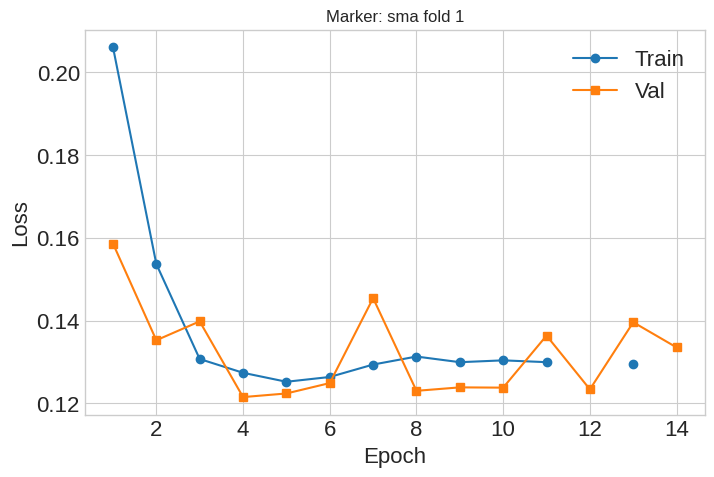

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 263MB/s]


###### Fold 2/4, marker sma ######
......example image shape: (667, 489, 39)
......extracting control and trg markers: 1 / 595
......extracting control and trg markers: 298 / 595
......extracting control and trg markers: 595 / 595
......fitting regression: 1 / 595
......fitting regression: 298 / 595
......fitting regression: 595 / 595
......normalization: 1 / 595
......normalization: 298 / 595
......normalization: 595 / 595
......PCA projection to 3D captures 85.80% variance
......available GPUs: 2
Epoch   1 | Train 0.194 | Val 0.147
  ↳ New best val=0.147 at epoch 1
  ↳ Saved checkpoint to best_model.pth
Epoch   2 | Train 0.155 | Val 0.127
  ↳ New best val=0.127 at epoch 2
  ↳ Saved checkpoint to best_model.pth
Epoch   3 | Train 0.134 | Val 0.118
  ↳ New best val=0.118 at epoch 3
  ↳ Saved checkpoint to best_model.pth
Epoch   4 | Train 0.129 | Val 0.127
  ↳ No improvement (1/10 patience)
Epoch   5 | Train 0.130 | Val 0.119
  ↳ No improvement (2/10 patience)
Epoch   6 | Train 0.132 | V

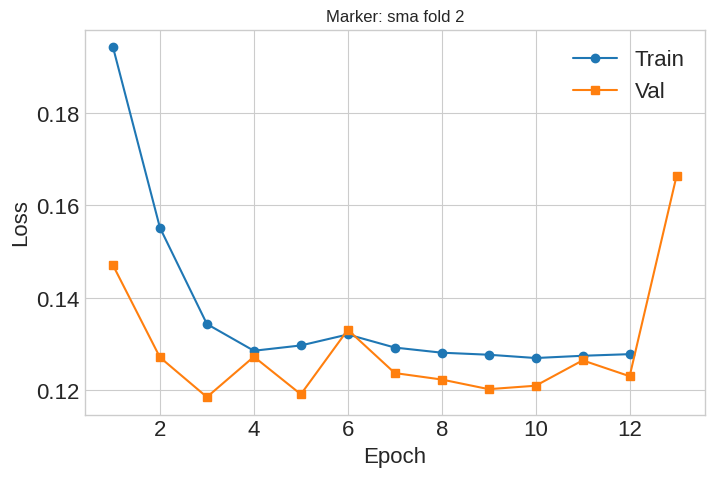

In [ ]:
dataset = "danenberg2022"
path = f"/kaggle/input/{dataset}"
control = [0,37,38] #histone_h3, dna1, dna2

marker_tasks = [
    #("ki67", 28, control),
    ("sma", 1, control),

    #("CD3", 13, control),
    #("CD20", 24, control),
    ("CD45", 22, control), 
    #("CD68", 11, control),
    
    ("pan_cytokeratin", 35, control), 
    ("cytokeratin_5", 2, control),
    ("cytokeratin_8_18", 5, control),

    #Keren 2018:
    #("CD11c", 15, control),
    #("CD16", 18, control),
    #("hla_dr", 4, control),
]

d_results = []
for title, target_idx, control_markers_indices in marker_tasks:
    start_time = time.time()
    print(f"Analyzing {dataset} dataset")
    
    res = main(path, target_idx, control_markers_indices, title=title, data_name = dataset)
    d_results.append(res)
    
    df_res = pd.DataFrame([res])
    df_res.to_csv(f"{dataset[0]}_results_{title}_5fold.csv", index=False)

    total_time = time.time() - start_time
    print(f"--Total training time for {title}: {total_time/60:.2f} minutes")

In [ ]:
dataset = "jackson2020"
path = f"/kaggle/input/{dataset}"
control = [0, 33, 34] #histone_h3, dna1, dna2

marker_tasks = [
    #("ki67", 25, control),
    ("sma", 9, control),

    #("CD3", 13, control),
    #("CD20", 22, control),
    ("CD45", 20, control),
    #("CD68", 7, control),
    
    ("pan_cytokeratin", 31, control),
    ("cytokeratin_5", 2, control),
    ("cytokeratin_8_18", 5, control),
]

j_results = []
for title, target_idx, control_markers_indices in marker_tasks:
    start_time = time.time()
    print(f"Analyzing {dataset} dataset")
    
    res = main(path, target_idx, control_markers_indices, title=title, data_name = dataset)
    
    df_res = pd.DataFrame([res])
    df_res.to_csv(f"{dataset[0]}_results_{title}_5fold.csv", index=False)

    j_results.append(res)

    total_time = time.time() - start_time
    print(f"--Total training time for {title}: {total_time/60:.2f} minutes")

# comparison

In [ ]:
#load results per marker into a dataframe. add column for avg across markers. 
j_df = pd.DataFrame(j_results)
d_df = pd.DataFrame(d_results)
plot_marker_comparison_hbar(d_df, j_df, metric="RMSE", label_A="Danenberg2022", label_B="Jackson2020")
plot_marker_comparison_hbar(d_df, j_df, metric="Pearson", label_A="Danenberg2022", label_B="Jackson2020")
plot_marker_comparison_hbar(d_df, j_df, metric="FID", label_A="Danenberg2022", label_B="Jackson2020")
'''